In [141]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class BoostedClassificationTrees:
    def __init__(self, max_tree_depth=2, num_iter=100) -> None:
        self.max_tree_depth = max_tree_depth
        self.num_iter = num_iter
        self.object_weights = None
        self.clf_weights = None
        self.trees = None

    # TODO: can make this more efficient by performing inference outside of the function one time. 
    def _num_negative(self, X_train: np.array, y_train: np.array, clf: DecisionTreeClassifier):
        y_pred = clf.predict(X_train)
        ind = np.where(y_pred != y_train, 1, 0)
        return np.dot(ind, self.object_weights)

    def _update_weights(self, X_train: np.array, y_train: np.array, alpha_t: float, clf: DecisionTreeClassifier):
        y_pred = clf.predict(X_train)
        raw_weights = self.object_weights * np.exp(-1 * y_pred * y_train * alpha_t)
        self.object_weights = raw_weights / np.sum(raw_weights)

    
    def fit(self, X_train: np.array, y_train: np.array) -> None:
        self.object_weights = np.ones(X_train.shape[0]) / X_train.shape[0]
        self.clf_weights = []
        self.trees = []

        for i in range(self.num_iter):
            dtc = DecisionTreeClassifier(max_depth=self.max_tree_depth)
            dtc.fit(X_train, y_train, sample_weight=self.object_weights)
            negatives = self._num_negative(X_train, y_train, dtc)
            alpha_t = 0.5 * np.log((1 - negatives) / negatives)

            self.trees.append(dtc)
            self.clf_weights.append(alpha_t)
            self._update_weights(X_train, y_train, alpha_t, dtc)

    def predict(self, X_test: np.array):
        if self.trees is None:
            raise(AssertionError("fit the model first before predicting."))
        preds = np.zeros(X_test.shape[0])
        for tree, weight in zip(self.trees, self.clf_weights):
            preds += tree.predict(X_test) * weight

        return np.where(preds > 0, 1, -1)

In [88]:
df = pd.read_csv('../data/mushrooms.csv')

In [89]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# loop through all columns of the dataframe and label encode them
for col in df.columns:
    df[col] = le.fit_transform(df[col])

train_df = df[[col for col in df.columns if col != 'class']]
label = df['class']
label = np.where(label == 1, 1, -1)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [126]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df.values, label, test_size=0.2)
X_train.shape, X_test.shape

((6499, 22), (1625, 22))

<AxesSubplot: >

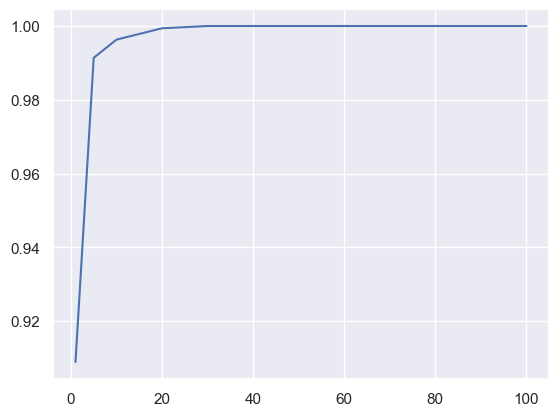

In [142]:
from sklearn.metrics import accuracy_score
import seaborn as sns

sns.set()

iter_grid = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accs = []
for i in iter_grid:
    clf = BoostedClassificationTrees(num_iter=i)
    clf.fit(X_train, y_train)
    accs.append(accuracy_score(y_test, clf.predict(X_test)))

sns.lineplot(x=iter_grid, y=accs)